In [2]:
import torch
import torch.nn as nn

In [3]:
# This UNET implementation is a modified version of code written by Muhammad Firmansyah Kasim.
# The original code can be found at https://github.com/mfkasim1/score-based-tutorial/blob/main/03-SGM-with-SDE-MNIST.ipynb

# MIT License

# Copyright (c) 2022 Muhammad Firmansyah Kasim

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


class Unet(torch.nn.Module):
    """
    A simple U-Net architecture for MNIST that takes an input image and time
    """

    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList(
            [
                torch.nn.Sequential(
                    torch.nn.Conv2d(
                        2, chs[0], kernel_size=3, padding=1
                    ),  # (batch, ch, 28, 28)
                    torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
                ),
                torch.nn.Sequential(
                    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                    torch.nn.Conv2d(
                        chs[0], chs[1], kernel_size=3, padding=1
                    ),  # (batch, ch, 14, 14)
                    torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
                ),
                torch.nn.Sequential(
                    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                    torch.nn.Conv2d(
                        chs[1], chs[2], kernel_size=3, padding=1
                    ),  # (batch, ch, 7, 7)
                    torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
                ),
                torch.nn.Sequential(
                    torch.nn.MaxPool2d(
                        kernel_size=2, stride=2, padding=1
                    ),  # (batch, ch, 4, 4)
                    torch.nn.Conv2d(
                        chs[2], chs[3], kernel_size=3, padding=1
                    ),  # (batch, ch, 4, 4)
                    torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
                ),
                torch.nn.Sequential(
                    torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                    torch.nn.Conv2d(
                        chs[3], chs[4], kernel_size=3, padding=1
                    ),  # (batch, ch, 2, 2)
                    torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
                ),
            ]
        )
        self._tconvs = torch.nn.ModuleList(
            [
                torch.nn.Sequential(
                    # input is the output of convs[4]
                    torch.nn.ConvTranspose2d(
                        chs[4],
                        chs[3],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),  # (batch, 64, 4, 4)
                    torch.nn.LogSigmoid(),
                ),
                torch.nn.Sequential(
                    # input is the output from the above sequential concated with the output from convs[3]
                    torch.nn.ConvTranspose2d(
                        chs[3] * 2,
                        chs[2],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=0,
                    ),  # (batch, 32, 7, 7)
                    torch.nn.LogSigmoid(),
                ),
                torch.nn.Sequential(
                    # input is the output from the above sequential concated with the output from convs[2]
                    torch.nn.ConvTranspose2d(
                        chs[2] * 2,
                        chs[1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),  # (batch, chs[2], 14, 14)
                    torch.nn.LogSigmoid(),
                ),
                torch.nn.Sequential(
                    # input is the output from the above sequential concated with the output from convs[1]
                    torch.nn.ConvTranspose2d(
                        chs[1] * 2,
                        chs[0],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),  # (batch, chs[1], 28, 28)
                    torch.nn.LogSigmoid(),
                ),
                torch.nn.Sequential(
                    # input is the output from the above sequential concated with the output from convs[0]
                    torch.nn.Conv2d(
                        chs[0] * 2, chs[0], kernel_size=3, padding=1
                    ),  # (batch, chs[0], 28, 28)
                    torch.nn.LogSigmoid(),
                    torch.nn.Conv2d(
                        chs[0], 1, kernel_size=3, padding=1
                    ),  # (batch, 1, 28, 28)
                ),
            ]
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

In [15]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm


class DDPM(nn.Module):
    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """

        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        self._network = network
        self.network = lambda x, t: (self._network(x, t / T))

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T + 1))
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        self.register_buffer("alphas_cumprod", self.alpha_bar)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(self.alpha_bar))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - self.alpha_bar)
        )
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / self.alpha_bar))

    def forward_diffusion(self, x0, t, epsilon):
        """
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon.
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        """

        X_t = (
            torch.sqrt(self.alpha_bar[t]) * x0
            + torch.sqrt(1 - self.alpha_bar[t]) * epsilon
        )
        return X_t

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """
        epsilon_theta = self.network(xt, t)

        mean = self.sqrt_recip_alphas[t] * (
            xt - (self.beta[t] / self.sqrt_one_minus_alphas_cumprod[t]) * epsilon_theta
        )

        if t.min() > 0:
            std = torch.sqrt(self.beta[t])
        else:
            std = 0.0

        return mean + std * epsilon

    # @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image
        """

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0], 1)).to(x0.device)

        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        return -nn.MSELoss(reduction="mean")(epsilon, self.network(xt, t))

    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


In [4]:
def train(
    model, optimizer, scheduler, dataloader, epochs, device, per_epoch_callback=None
):
    """
    Training loop

    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader) * epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):
        # Switch to train mode
        model.train()

        for i, (x, _) in enumerate(dataloader):
            # x, _ = data
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(
                loss=f"⠀{loss.item():12.4f}",
                epoch=f"{epoch+1}/{epochs}",
                lr=f"{scheduler.get_last_lr()[0]:.2E}",
            )
            progress_bar.update()

        if per_epoch_callback:
            per_epoch_callback(model)


In [6]:
# Parameters
T = 200
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(
            lambda x: x + torch.rand(x.shape) / 255
        ),  # Dequantize pixel values
        transforms.Lambda(lambda x: (x - 0.5) * 2.0),  # Map from [0,1] -> [-1, -1]
        transforms.Lambda(lambda x: x.flatten()),
    ]
)

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST("../data", download=True, train=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Construct Unet
mnist_unet = Unet()

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


In [6]:
def reporter(model):
    """Callback function used for plotting images during training"""

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples, 28 * 28)).cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples + 1) / 2

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()


In [ ]:
# Call training loop
train(
    model,
    optimizer,
    scheduler,
    dataloader_train,
    epochs=epochs,
    device=device,
    per_epoch_callback=None,
)

torch.save(model.state_dict(), "model_weights.pth")


Training:   0%|          | 0/23500 [00:00<?, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
ERROR:tornado.general:SEND Error: Host unreachable


AttributeError: 'DDPM' object has no attribute 'model'

In [16]:
# Construct Unet
mnist_unet = Unet()

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

state_dict = torch.load(
    "model_weights.pth", weights_only=True, map_location=torch.device("cpu")
)

model.load_state_dict(state_dict)
model.eval()

DDPM(
  (_network): Unet(
    (_convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LogSigmoid()
      )
      (1): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LogSigmoid()
      )
      (2): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LogSigmoid()
      )
      (3): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
        (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): LogSigmoid()
      )
      (4): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Conv2d(256, 25

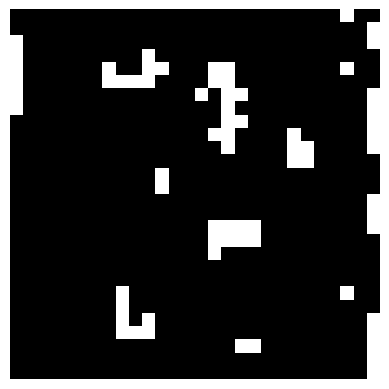

In [17]:
with torch.no_grad():
    nsamples = 1
    samples = model.sample((nsamples, 28 * 28)).cpu()

    # Map pixel values back from [-1,1] to [0,1]
    samples = (samples + 1) / 2

    # Plot in grid
    grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
    plt.gca().set_axis_off()
    plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
    plt.show()